In [62]:
import pandas as pd
from stable_baselines3.common.logger import configure

from finrl.agents.stablebaselines3.models import DRLAgent as StockDRLAgent
from finrl.agents.portfolio_optimization.models import DRLAgent as OptDRLAgent
from finrl.agents.portfolio_optimization.models_stable import DRLStableAgent

from finrl.config import TRAINED_MODEL_DIR, RESULTS_DIR
from finrl.main import check_and_make_directories
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv

import numpy as np


TIME_WINDOW = 50
COMMISSION_FEE_PERCENT = 0.001
INITIAL_CASH = 1000000

TRAIN_START_DATE = '2009-04-01'
TRAIN_END_DATE = '2021-12-31'
TEST_START_DATE = '2022-01-01'
TEST_END_DATE = '2024-01-01'

TRAINED_PPO = "/agent_opt_ppo_update"

GRAPH_TITLE = "EIIE Trained 2009-2021, 40 episodes"

# Backtest the results

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader

TEST_TICKER = [
   "MSFT",
    "V",
    "AAPL",
    "BA",
    "INTC",
    "WMT",
]

PORT = TEST_TICKER

df = YahooDownloader(start_date = TEST_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = PORT).fetch_data()

processed = df.copy()
processed = processed.fillna(0)
processed_test = processed.replace(np.inf,0)

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3006, 8)


# Portfolio Optimization Algorithm

In [63]:
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv


# Fit for the portfolio optimization model

from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler

portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(processed_test)
portfolio_norm_df


environment = PortfolioOptimizationEnv(
    portfolio_norm_df,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.57221662 0.54386261 0.51772489 0.53068422 0.47485296 0.5846902
 0.41696312 0.40966254 0.46278683 0.4405253  0.49811448 0.51924404
 0.50065443 0.67276864 0.88878873 0.63415735 0.59295791 0.66787111
 0.9853983  0.63275101 0.47214105 0.46502393 0.4896885  0.4516128
 0.4230578  0.40979398 0.39038455 0.49761722 0.54035936 0.47198552
 0.34242451 0.33503138 0.38109824 0.45329569 0.49924316 0.4929256
 0.77297894 0.50368671 0.52056714 0.45713848 0.4366042  0.41992092
 0.45857767 0.52802708 0.71821941 0.50084282 0.57689401 0.53104621
 0.59545952 0.50910888 0.56023592 0.41409952 0.6763984  0.52470072
 0.44650113 0.53702971 0.49359481 0.44110251 0.49491188 0.55086691
 0.50729565 0.56433829 0.43127293 0.41877088 0.40197698 0.48772084
 0.42493894 0.4193574  0.395651

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.   0.25 0.5  0.75 1.   0.   0.25 0.5  0.75 1.   0.25 0.5  0.75 1.
 0.   0.25 0.5  0.75 1.   0.   0.25 0.5  0.75 1.   0.   0.25 0.5  0.75
 1.   0.   0.25 0.5  0.75 1.   0.25 0.5  0.75 1.   0.   0.25 0.5  0.75
 1.   0.   0.25 0.5  0.75 1.   0.   0.25 0.5  0.75 1.   0.   0.25 0.5
 0.75 1.   0.   0.25 0.5  0.75 1.   0.   0.25 0.5  0.75 1.   0.   0.25
 0.5  0.75 0.   0.25 0.5  0.75 1.   0.   0.25 0.5  0.75 1.   0.   0.25
 0.5  0.75 1.   0.   0.25 0.5  0.75 1.   0.   0.25 0.5  0.75 1.   0.
 0.25 0.5  0.75 1.   0.25 0.5  0.75 1.   0.   0.25 0.5  0.75 1.   0.
 0.25 0.5  0.75 1.   0.25 0.5  0.75 1.   0.   0.25 0.5  0.75 1.   0.25
 0.5  0.75 1.   0.   0.25 0.5  0.75 1.   0.   0.25 0.5  0.75 1.   0.
 0.25 0.5  0.75 1.   0.   0.25 0.5  0.75 1.   0.   0.25 0.5  0.7

In [64]:
import torch
from finrl.agents.portfolio_optimization.architectures import EIIE

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# set PolicyGradient parameters
model_kwargs = {
    "lr": 0.01,
    "policy": EIIE,
}

# here, we can set EIIE's parameters
policy_kwargs = {
    "k_size": 3,
    "time_window": TIME_WINDOW,
}


# instantiate an architecture with the same arguments used in training
# and load with load_state_dict.
policy = EIIE(time_window=TIME_WINDOW, device=device)
policy.load_state_dict(torch.load("policy_EIIE.pt"))

C:\Users\bencj\AppData\Local\Temp\ipykernel_28604\3962532677.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy.load_state_dict(torch.load("policy_EIIE.pt"))


<All keys matched successfully>

In [65]:
EIIE_results = {
    "test": {},
}

# 2021 - 2024
# Initialize the model
model = OptDRLAgent(environment).get_model("pg", device, model_kwargs, policy_kwargs)
OptDRLAgent.DRL_validation(model, environment, policy=policy)
EIIE_results["test"]["value"] = environment._asset_memory["final"]
EIIE_results["test"]["date"] = environment._date_memory



# Write this out to a csv file, with date and net worth
df_opt = pd.DataFrame(EIIE_results["test"]["value"], columns=['eiie_net_worth'])
df_date = pd.DataFrame(EIIE_results["test"]["date"], columns=['Date'])
if len(df_opt) == len(df_date):
    df_opt['Date'] = df_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")


# The optimization algoirhtm has a shorter window than the full df, so shorted this for the follow algorithm
opt_start = df_opt.loc[0,'Date']


Initial portfolio value:1000000
Final portfolio value: 1361420.125
Final accumulative portfolio value: 1.361420125
Maximum DrawDown: -0.40557114752373447
Sharpe ratio: 0.6151944379117776


In [66]:
print(df_opt)

     eiie_net_worth       Date
0      1.000000e+06 2022-03-15
1      1.050535e+06 2022-03-16
2      1.057201e+06 2022-03-17
3      1.071877e+06 2022-03-18
4      1.033363e+06 2022-03-21
..              ...        ...
447    1.300461e+06 2023-12-22
448    1.368193e+06 2023-12-26
449    1.375238e+06 2023-12-27
450    1.365213e+06 2023-12-28
451    1.361420e+06 2023-12-29

[452 rows x 2 columns]


In [67]:
opt_end = df_opt.loc[len(df_date)-1,'Date']

print(opt_start)
opt_start = opt_start.strftime('%Y-%m-%d %H:%M:%S')


print(opt_end)
opt_end = opt_end.strftime('%Y-%m-%d %H:%M:%S')

2022-03-15 00:00:00
2023-12-29 00:00:00


In [68]:
from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler

from finrl.meta.preprocessor.preprocessors import data_split

from datetime import datetime, timedelta
# Make sure dates line up
# Make sure we only test on the same data as the portfolio optimization algorithm
# Convert to datetime
opt_start_date = datetime.strptime(opt_start, '%Y-%m-%d %H:%M:%S')

# Subtract one day
new_opt_start_date = opt_start_date - timedelta(days=1)

# Convert back to string
new_opt_start_str = new_opt_start_date.strftime('%Y-%m-%d %H:%M:%S')

test = data_split(portfolio_norm_df, new_opt_start_str,opt_end)


portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(test)
portfolio_norm_df


environment_benchmarks = PortfolioOptimizationEnv(
    portfolio_norm_df,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    # time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)

# Porfolio Baselines

In [69]:
# CRP 

CRP_results = {
    "test": {},
}

environment_benchmarks.reset()
agent_crp = DRLStableAgent(env = environment_benchmarks)
model_crp = agent_crp.get_model("crp", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_crp, environment_benchmarks)
CRP_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
CRP_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_crp_opt = pd.DataFrame(CRP_results["test"]["value"], columns=['crp_opt_net_worth'])
df_crp_date = pd.DataFrame(CRP_results["test"]["date"], columns=['Date'])
if len(df_crp_opt) == len(df_crp_date):
    df_crp_opt['Date'] = df_crp_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_crp_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_crp_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_crp_opt.loc[len(df_crp_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1312322.5
Final accumulative portfolio value: 1.3123225
Maximum DrawDown: -0.2832145455452737
Sharpe ratio: 0.797951264244929
hit end!
     crp_opt_net_worth       Date
0         1.000000e+06 2022-03-15
1         1.028380e+06 2022-03-16
2         1.034459e+06 2022-03-17
3         1.049716e+06 2022-03-18
4         1.040846e+06 2022-03-21
..                 ...        ...
447       1.299309e+06 2023-12-22
448       1.312241e+06 2023-12-26
449       1.314405e+06 2023-12-27
450       1.313351e+06 2023-12-28
451       1.312322e+06 2023-12-29

[452 rows x 2 columns]


In [70]:
# BAH

BAH_results = {
    "test": {},
}

environment_benchmarks.reset()
agent_bah = DRLStableAgent(env = environment_benchmarks)
model_bah = agent_bah.get_model("bah", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_bah, environment_benchmarks)
BAH_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
BAH_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_bah_opt = pd.DataFrame(BAH_results["test"]["value"], columns=['bah_opt_net_worth'])
df_bah_date = pd.DataFrame(BAH_results["test"]["date"], columns=['Date'])
if len(df_bah_opt) == len(df_bah_date):
    df_bah_opt['Date'] = df_bah_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_bah_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_bah_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_bah_opt.loc[len(df_bah_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1268936.75
Final accumulative portfolio value: 1.26893675
Maximum DrawDown: -0.28475808057832896
Sharpe ratio: 0.7258943996911178
hit end!
     bah_opt_net_worth       Date
0         1.000000e+06 2022-03-15
1         1.028380e+06 2022-03-16
2         1.034507e+06 2022-03-17
3         1.049810e+06 2022-03-18
4         1.040872e+06 2022-03-21
..                 ...        ...
447       1.257444e+06 2023-12-22
448       1.269205e+06 2023-12-26
449       1.270892e+06 2023-12-27
450       1.269837e+06 2023-12-28
451       1.268937e+06 2023-12-29

[452 rows x 2 columns]


In [71]:
# OLMAR

OLMAR_results = {
    "test": {},
}

# OLMAR_model_kwargs = {
#     "eps": 60,
#     "window": 100
# }


environment_benchmarks.reset()
agent_olmar = DRLStableAgent(env = environment_benchmarks)
model_olmar = agent_olmar.get_model("olmar", model_kwargs=None)

values, dates = DRLStableAgent.DRL_prediction(model_olmar, environment_benchmarks)
OLMAR_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
OLMAR_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_olmar_opt = pd.DataFrame(OLMAR_results["test"]["value"], columns=['olmar_opt_net_worth'])
df_olmar_date = pd.DataFrame(OLMAR_results["test"]["date"], columns=['Date'])
if len(df_olmar_opt) == len(df_olmar_date):
    df_olmar_opt['Date'] = df_olmar_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_olmar_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_olmar_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_olmar_opt.loc[len(df_olmar_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1031970.4375
Final accumulative portfolio value: 1.0319704375
Maximum DrawDown: -0.41663516061579264
Sharpe ratio: 0.22361611785282054
hit end!
     olmar_opt_net_worth       Date
0           1.000000e+06 2022-03-15
1           1.028380e+06 2022-03-16
2           1.033193e+06 2022-03-17
3           1.047535e+06 2022-03-18
4           1.009888e+06 2022-03-21
..                   ...        ...
447         1.032915e+06 2023-12-22
448         1.029980e+06 2023-12-26
449         1.030514e+06 2023-12-27
450         1.032808e+06 2023-12-28
451         1.031970e+06 2023-12-29

[452 rows x 2 columns]


In [72]:
# RMR

RMR_results = {
    "test": {},
}

# RMR_model_kwargs = {
#     "eps": 60,
#     "window": 100
# }

environment_benchmarks.reset()
agent_rmr = DRLStableAgent(env = environment_benchmarks)
model_rmr = agent_rmr.get_model("rmr", model_kwargs=None)

values, dates = DRLStableAgent.DRL_prediction(model_rmr, environment_benchmarks)
RMR_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
RMR_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_rmr_opt = pd.DataFrame(RMR_results["test"]["value"], columns=['rmr_opt_net_worth'])
df_rmr_date = pd.DataFrame(RMR_results["test"]["date"], columns=['Date'])
if len(df_rmr_opt) == len(df_rmr_date):
    df_rmr_opt['Date'] = df_rmr_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_rmr_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_rmr_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_rmr_opt.loc[len(df_rmr_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 573253.625
Final accumulative portfolio value: 0.573253625
Maximum DrawDown: -0.5461683304030859
Sharpe ratio: -0.9739027147031752
hit end!
     rmr_opt_net_worth       Date
0         1.000000e+06 2022-03-15
1         1.028380e+06 2022-03-16
2         1.033193e+06 2022-03-17
3         1.047535e+06 2022-03-18
4         1.009888e+06 2022-03-21
..                 ...        ...
447       5.727699e+05 2023-12-22
448       5.779381e+05 2023-12-26
449       5.764206e+05 2023-12-27
450       5.725719e+05 2023-12-28
451       5.732536e+05 2023-12-29

[452 rows x 2 columns]


In [73]:
# BNN

BNN_results = {
    "test": {},
}

# RMR_model_kwargs = {
#     "eps": 60,
#     "window": 100
# }

environment_benchmarks.reset()
agent_bnn = DRLStableAgent(env = environment_benchmarks)
model_bnn = agent_bnn.get_model("bnn", model_kwargs=None)

values, dates = DRLStableAgent.DRL_prediction(model_bnn, environment_benchmarks)
BNN_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
BNN_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_bnn_opt = pd.DataFrame(BNN_results["test"]["value"], columns=['bnn_opt_net_worth'])
df_bnn_date = pd.DataFrame(BNN_results["test"]["date"], columns=['Date'])
if len(df_bnn_opt) == len(df_bnn_date):
    df_bnn_opt['Date'] = df_bnn_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_bnn_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_bnn_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_bnn_opt.loc[len(df_bnn_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 521503.6875
Final accumulative portfolio value: 0.5215036875
Maximum DrawDown: -0.56197628125
Sharpe ratio: -1.1707198123395222
hit end!
     bnn_opt_net_worth       Date
0        1000000.00000 2022-03-15
1        1000000.00000 2022-03-16
2        1000000.00000 2022-03-17
3        1000000.00000 2022-03-18
4        1000000.00000 2022-03-21
..                 ...        ...
447       521063.59375 2023-12-22
448       525765.25000 2023-12-26
449       524384.75000 2023-12-27
450       520883.50000 2023-12-28
451       521503.68750 2023-12-29

[452 rows x 2 columns]


In [74]:
# SCRP

HISTORY_START_DATE = TRAIN_START_DATE
HISTORY_END_DATE = TRAIN_END_DATE

# Download the history data for scrp

history_df = YahooDownloader(start_date = HISTORY_START_DATE,
                     end_date = HISTORY_END_DATE,
                     ticker_list = PORT).fetch_data()


history_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(history_df)

SCRP_results = {
    "test": {},
}

history_df_environment = PortfolioOptimizationEnv(
        history_df,
        initial_amount=INITIAL_CASH,
        comission_fee_pct=COMMISSION_FEE_PERCENT,
        # time_window=TIME_WINDOW,
        features=["close"],
        normalize_df=None
    )

# Pull out the historical price data for SCRP over the training period
agent_history_scrp = DRLStableAgent(env = history_df_environment)
history_scrp = agent_history_scrp.get_model("scrp")

_, _ = DRLStableAgent.DRL_prediction(history_scrp, history_df_environment)


# now make the predictions with the historical price data, but in the test period only
SCRP_model_kwargs = {
    "price_history": history_scrp.price_history
}

environment_benchmarks.reset()
agent_scrp = DRLStableAgent(env = environment_benchmarks)
model_scrp = agent_scrp.get_model("scrp", model_kwargs=SCRP_model_kwargs)

values, dates = DRLStableAgent.DRL_prediction(model_scrp, environment_benchmarks)
SCRP_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
SCRP_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_scrp_opt = pd.DataFrame(SCRP_results["test"]["value"], columns=['scrp_opt_net_worth'])
df_scrp_date = pd.DataFrame(SCRP_results["test"]["date"], columns=['Date'])
if len(df_scrp_opt) == len(df_scrp_date):
    df_scrp_opt['Date'] = df_scrp_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_scrp_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_scrp_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_scrp_opt.loc[len(df_scrp_opt)-1,'Date']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.31332941 0.43188074 0.33824661 ... 0.0420757  0.03314671 0.03177728]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[select_mask, self.columns] = self.scalers[value].transform(


Shape of DataFrame:  (19266, 8)


c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.5  0.75 1.   ... 0.25 0.5  0.75]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  X.loc[select_mask, self.columns] = self.scalers[value].transform(
c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 34645340.0
Final accumulative portfolio value: 34.64534
Maximum DrawDown: -0.4379716792908388
Sharpe ratio: 1.1275175162577322
hit end!


c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1253995.875
Final accumulative portfolio value: 1.253995875
Maximum DrawDown: -0.29824750311061754
Sharpe ratio: 0.5816547110680279
hit end!
     scrp_opt_net_worth       Date
0          1.000000e+06 2022-03-15
1          1.029015e+06 2022-03-16
2          1.035657e+06 2022-03-17
3          1.057322e+06 2022-03-18
4          1.066349e+06 2022-03-21
..                  ...        ...
447        1.260965e+06 2023-12-22
448        1.257383e+06 2023-12-26
449        1.258034e+06 2023-12-27
450        1.260835e+06 2023-12-28
451        1.253996e+06 2023-12-29

[452 rows x 2 columns]


# Try BCRP extreme, which is the absolute best portfolio over the period with hindsight


In [75]:
# bcrp

BCRP_results = {
    "test": {},
}

environment_benchmarks.reset()
agent_bcrp= DRLStableAgent(env = environment_benchmarks)
model_bcrp= agent_bcrp.get_model("bcrp", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_bcrp, environment_benchmarks)
BCRP_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
BCRP_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_bcrp_opt = pd.DataFrame(BCRP_results["test"]["value"], columns=['bcrp_opt_net_worth'])
df_bcrp_date = pd.DataFrame(BCRP_results["test"]["date"], columns=['Date'])
if len(df_bcrp_opt) == len(df_bcrp_date):
    df_bcrp_opt['Date'] = df_bcrp_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_bcrp_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_bcrp_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_bcrp_opt.loc[len(df_bcrp_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1280553.0
Final accumulative portfolio value: 1.280553
Maximum DrawDown: -0.2183737333267216
Sharpe ratio: 0.7192761039883078
hit end!
     bcrp_opt_net_worth       Date
0          1.000000e+06 2022-03-15
1          1.027797e+06 2022-03-16
2          1.035461e+06 2022-03-17
3          1.062918e+06 2022-03-18
4          1.052877e+06 2022-03-21
..                  ...        ...
447        1.271110e+06 2023-12-22
448        1.274700e+06 2023-12-26
449        1.273569e+06 2023-12-27
450        1.280799e+06 2023-12-28
451        1.280553e+06 2023-12-29

[452 rows x 2 columns]


# Stock environment optimization algorithm

In [76]:
# Pull the DJI results

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline


df_dji_ = get_baseline(
        ticker="^DJI",
        start = df_date.loc[0,'Date'],
        end = df_date.loc[len(df_date)-1,'Date'])

stats = backtest_stats(df_dji_, value_col_name = 'close')

df_dji = pd.DataFrame()
df_dji['date'] = df_date['Date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * INITIAL_CASH
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
print("df_dji: ", df_dji)


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (451, 8)
Annual return          0.067595
Cumulative returns     0.124187
Annual volatility      0.160670
Sharpe ratio           0.488293
Calmar ratio           0.363193
Stability              0.287241
Max drawdown          -0.186112
Omega ratio            1.086789
Sortino ratio          0.695851
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.989564
Daily value at risk   -0.019931
dtype: float64
df_dji:            date           dji
0   2022-03-15  1.000000e+06
1   2022-03-16  1.015465e+06
2   2022-03-17  1.027916e+06
3   2022-03-18  1.036089e+06
4   2022-03-21  1.030069e+06
..         ...           ...
447 2023-12-22  1.114524e+06
448 2023-12-26  1.119275e+06
449 2023-12-27  1.122589e+06
450 2023-12-28  1.124187e+06
451 2023-12-29           NaN

[452 rows x 2 columns]
df_dji:                       dji
date                    
2022-03-15  1.000000e+06
2022-03-16  1.015465e+06
2022-03-17  1.027916e+06
2022-03-18  1.036089e+06

# Compare all results

In [77]:
# Join the online algorithms

# bcrp = pd.read_csv('BCRP_net_worth.csv')
# crp = pd.read_csv('CRP_net_worth.csv')


# Merge the baseline CRP algorithm
df_crp_opt['Date'] = pd.to_datetime(df_crp_opt['Date'])
merged_df = df_crp_opt

# Merge the baseline BCRP algorithm
df_bcrp_opt['Date'] = pd.to_datetime(df_bcrp_opt['Date'])
merged_df = pd.merge(merged_df, df_bcrp_opt, on='Date')

# Merge the baseline BAH algorithm
df_bah_opt['Date'] = pd.to_datetime(df_bah_opt['Date'])
merged_df = pd.merge(merged_df, df_bah_opt, on='Date')

# Merge the baseline OLMAR algorithm
df_olmar_opt['Date'] = pd.to_datetime(df_olmar_opt['Date'])
merged_df = pd.merge(merged_df, df_olmar_opt, on='Date')

# Merge the baseline RMR algorithm
df_rmr_opt['Date'] = pd.to_datetime(df_rmr_opt['Date'])
merged_df = pd.merge(merged_df, df_rmr_opt, on='Date')

# Merge the baseline BNN algorithm
df_bnn_opt['Date'] = pd.to_datetime(df_bnn_opt['Date'])
merged_df = pd.merge(merged_df, df_bnn_opt, on='Date')

# Merge the baseline SCRP algorithm
df_scrp_opt['Date'] = pd.to_datetime(df_scrp_opt['Date'])
merged_df = pd.merge(merged_df, df_scrp_opt, on='Date')

# Merge the opt algorithm
df_opt['Date'] = pd.to_datetime(df_opt['Date'])
merged_df = pd.merge(merged_df, df_opt, on='Date')



print(df_dji)
df_dji = df_dji.reset_index()
df_dji.rename(columns={'date': 'Date'}, inplace=True)
merged_df = pd.merge(merged_df, df_dji, on='Date')


print(merged_df)


                     dji
date                    
2022-03-15  1.000000e+06
2022-03-16  1.015465e+06
2022-03-17  1.027916e+06
2022-03-18  1.036089e+06
2022-03-21  1.030069e+06
...                  ...
2023-12-22  1.114524e+06
2023-12-26  1.119275e+06
2023-12-27  1.122589e+06
2023-12-28  1.124187e+06
2023-12-29           NaN

[452 rows x 1 columns]
     crp_opt_net_worth       Date  bcrp_opt_net_worth  bah_opt_net_worth  \
0         1.000000e+06 2022-03-15        1.000000e+06       1.000000e+06   
1         1.028380e+06 2022-03-16        1.027797e+06       1.028380e+06   
2         1.034459e+06 2022-03-17        1.035461e+06       1.034507e+06   
3         1.049716e+06 2022-03-18        1.062918e+06       1.049810e+06   
4         1.040846e+06 2022-03-21        1.052877e+06       1.040872e+06   
..                 ...        ...                 ...                ...   
447       1.299309e+06 2023-12-22        1.271110e+06       1.257444e+06   
448       1.312241e+06 2023-12-26        1.

# Baseline CRP in the environment

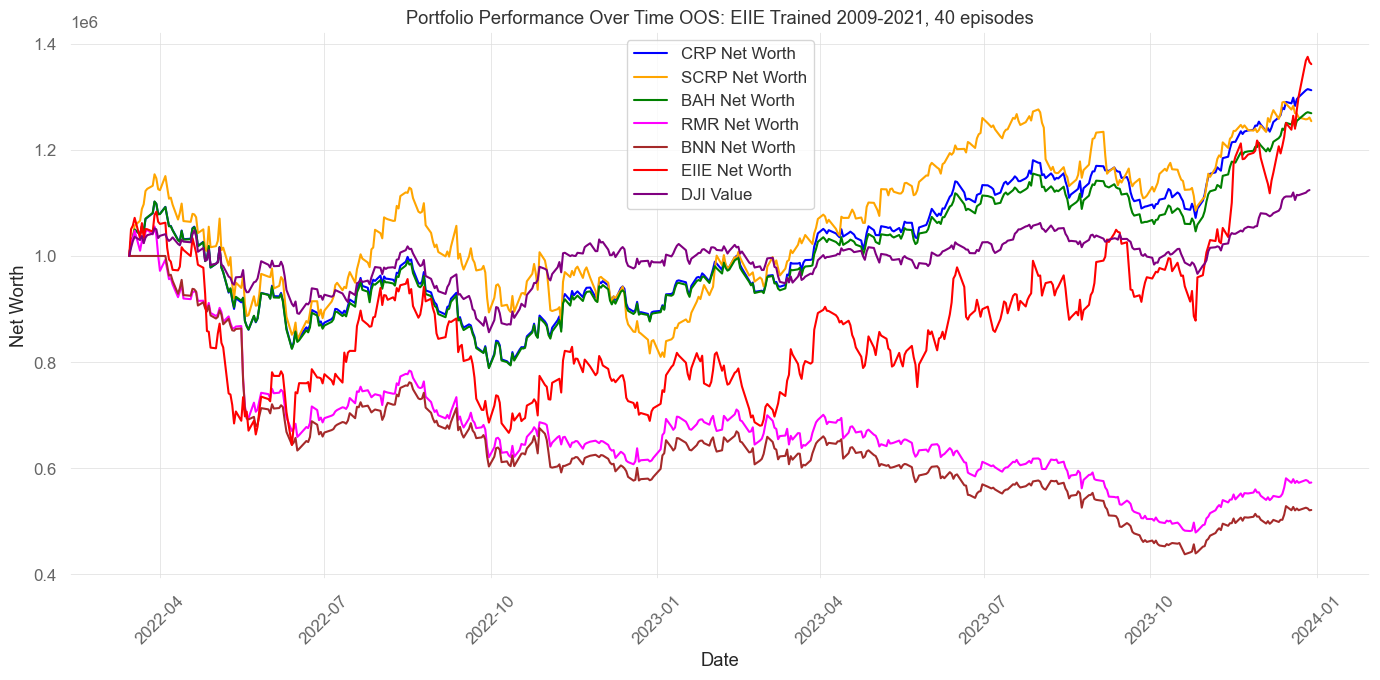

In [78]:
# Use the correct backend for Jupyter
%matplotlib inline
import matplotlib.pyplot as plt

# TODO make sure all dates line up, fix CRP and OLMAR 

import matplotlib.pyplot as plt

# Define a color map for the labels
color_map = {
    'CRP Net Worth': 'blue',
    'BAH Net Worth': 'green',
    'EIIE Net Worth': 'red',
    'DJI Value': 'purple',
    'SCRP Net Worth': 'orange',
    'OLMAR Net Worth': 'cyan',
    'RMR Net Worth': 'magenta',
    'BNN Net Worth': 'brown'
}




plt.figure(figsize=(14, 7))
plt.plot(merged_df['Date'], merged_df['crp_opt_net_worth'], label='CRP Net Worth', color=color_map['CRP Net Worth'])
plt.plot(merged_df['Date'], merged_df['scrp_opt_net_worth'], label='SCRP Net Worth', color=color_map['SCRP Net Worth'])
plt.plot(merged_df['Date'], merged_df['bah_opt_net_worth'], label='BAH Net Worth', color=color_map['BAH Net Worth'])
# plt.plot(merged_df['Date'], merged_df['olmar_opt_net_worth'], label='OLMAR Net Worth', color=color_map['OLMAR Net Worth'])
plt.plot(merged_df['Date'], merged_df['rmr_opt_net_worth'], label='RMR Net Worth', color=color_map['RMR Net Worth'])
plt.plot(merged_df['Date'], merged_df['bnn_opt_net_worth'], label='BNN Net Worth', color=color_map['BNN Net Worth'])
plt.plot(merged_df['Date'], merged_df['eiie_net_worth'], label='EIIE Net Worth', color=color_map['EIIE Net Worth'])
plt.plot(merged_df['Date'], merged_df['dji'], label='DJI Value', color=color_map['DJI Value'])
plt.xlabel('Date')
plt.ylabel('Net Worth')
plt.title('Portfolio Performance Over Time OOS: ' + GRAPH_TITLE)
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [79]:
import pprint

final_returns = {
   'BCRP OPT': merged_df['bcrp_opt_net_worth'].iloc[-1],
    'CRP': merged_df['crp_opt_net_worth'].iloc[-1],
    'SCRP': merged_df['scrp_opt_net_worth'].iloc[-1],
    'BAH': merged_df['bah_opt_net_worth'].iloc[-1],
    'OLMAR': merged_df['olmar_opt_net_worth'].iloc[-1],
    'RMR': merged_df['rmr_opt_net_worth'].iloc[-1],
    'BNN': merged_df['bnn_opt_net_worth'].iloc[-1],
    'EIIE': merged_df['eiie_net_worth'].iloc[-1],
}

pprint.pprint(final_returns)

{'BAH': 1268936.75,
 'BCRP OPT': 1280553.0,
 'BNN': 521503.6875,
 'CRP': 1312322.5,
 'EIIE': 1361420.125,
 'OLMAR': 1031970.4375,
 'RMR': 573253.625,
 'SCRP': 1253995.875}


In [80]:
import numpy as np
import pprint

# Calculate the returns each day

# merged_df['BCRP_daily_return'] = merged_df['BCRP_net_worth'].pct_change()
# merged_df['CRP_daily_return'] = merged_df['CRP_net_worth'].pct_change()
merged_df['BCRP_opt_daily_return'] = merged_df['bcrp_opt_net_worth'].pct_change()
merged_df['CRP_opt_daily_return'] = merged_df['crp_opt_net_worth'].pct_change()
merged_df['SCRP_opt_daily_return'] = merged_df['scrp_opt_net_worth'].pct_change()

merged_df['BAH_opt_daily_return'] = merged_df['bah_opt_net_worth'].pct_change()
merged_df['OLMAR_opt_daily_return'] = merged_df['olmar_opt_net_worth'].pct_change()
merged_df['RMR_opt_daily_return'] = merged_df['rmr_opt_net_worth'].pct_change()
merged_df['BNN_opt_daily_return'] = merged_df['bnn_opt_net_worth'].pct_change()

merged_df['EIIE_daily_return'] = merged_df['eiie_net_worth'].pct_change()


# merged_df['OLMAR_daily_return'] = merged_df['OLMAR_net_worth'].pct_change()


# TODO need to put in the fama french

# Define the risk-free rate (annual, for example, 2%)
risk_free_rate = 0.02 / 252  # Convert annual risk-free rate to daily

# Define a function to calculate Sharpe ratio adjusted for the risk-free rate
def calculate_sharpe_ratio(returns, risk_free_rate):
    excess_return = returns - risk_free_rate
    mean_excess_return = excess_return.mean()
    std_excess_return = excess_return.std()
    annual_factor = np.sqrt(252)  # Assuming 252 trading days in a year
    sharpe_ratio = annual_factor * mean_excess_return / std_excess_return
    return sharpe_ratio

# Calculate the Sharpe ratio for each daily return column
sharpe_ratios = {
    # 'BCRP': calculate_sharpe_ratio(merged_df['BCRP_daily_return'], risk_free_rate),
    # 'CRP': calculate_sharpe_ratio(merged_df['CRP_daily_return'], risk_free_rate),
    'BCRP': calculate_sharpe_ratio(merged_df['BCRP_opt_daily_return'], risk_free_rate),
    'CRP': calculate_sharpe_ratio(merged_df['CRP_opt_daily_return'], risk_free_rate),
    'SCRP': calculate_sharpe_ratio(merged_df['SCRP_opt_daily_return'], risk_free_rate),
    'BAH': calculate_sharpe_ratio(merged_df['BAH_opt_daily_return'], risk_free_rate),
    'OLMAR': calculate_sharpe_ratio(merged_df['OLMAR_opt_daily_return'], risk_free_rate),
    'RMR': calculate_sharpe_ratio(merged_df['RMR_opt_daily_return'], risk_free_rate),
    'BNN': calculate_sharpe_ratio(merged_df['BNN_opt_daily_return'], risk_free_rate),
    'EIIE': calculate_sharpe_ratio(merged_df['EIIE_daily_return'], risk_free_rate),
    # 'OLMAR old': calculate_sharpe_ratio(merged_df['OLMAR_daily_return'], risk_free_rate),
    # 'Opt': calculate_sharpe_ratio(merged_df['opt_daily_return'], risk_free_rate),

}

pprint.pprint(sharpe_ratios)

{'BAH': 0.6336412701654764,
 'BCRP': 0.632288248831595,
 'BNN': -1.2442004026694728,
 'CRP': 0.7081612463977447,
 'EIIE': 0.5691074317661717,
 'OLMAR': 0.16643752830310707,
 'RMR': -1.0467963284368795,
 'SCRP': 0.512986207698547}


In [81]:
import pandas as pd
import numpy as np

# Assuming merged_df is your DataFrame
# Calculate the max drawdown for each specified column
def max_drawdown(series):
    cumulative_returns = series.cummax()
    drawdowns = series / cumulative_returns - 1
    max_drawdown_value = drawdowns.min()
    return max_drawdown_value

max_drawdowns = {
    # 'BCRP': max_drawdown(merged_df['BCRP_net_worth']),
    # 'CRP': max_drawdown(merged_df['CRP_net_worth']),
    'BCRP': max_drawdown(merged_df['bcrp_opt_net_worth']),
    'CRP': max_drawdown(merged_df['crp_opt_net_worth']),
    'SCRP': max_drawdown(merged_df['scrp_opt_net_worth']),
    'BAH': max_drawdown(merged_df['bah_opt_net_worth']),
    'OLMAR': max_drawdown(merged_df['olmar_opt_net_worth']),
    'RMR': max_drawdown(merged_df['rmr_opt_net_worth']),
    'BNN': max_drawdown(merged_df['bnn_opt_net_worth']),
    'EIIE': max_drawdown(merged_df['eiie_net_worth']),
    # 'Opt': max_drawdown(merged_df['opt_net_worth']),
}

pprint.pprint(max_drawdowns)


{'BAH': -0.28475808057832896,
 'BCRP': -0.2183737333267216,
 'BNN': -0.56197628125,
 'CRP': -0.2832145455452737,
 'EIIE': -0.40557114752373447,
 'OLMAR': -0.41663516061579264,
 'RMR': -0.5461683304030859,
 'SCRP': -0.29824750311061754}


In [82]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols


# TODO can we do a statisitical significance test with anova here?
ANOVA_cols = ['EIIE_daily_return', 'BAH_opt_daily_return']
cols = ['Date',] + ANOVA_cols


df_selected = merged_df[cols]

# Assuming merged_df is your DataFrame and daily returns have already been calculated
# Combine all return columns into one DataFrame for ANOVA
returns_long = df_selected.melt(
    id_vars=['Date'], 
    value_vars=ANOVA_cols,
    var_name='Portfolio', 
    value_name='Daily_Return'
)

# Remove any NaN values created by pct_change()
returns_long.dropna(inplace=True)

# Perform ANOVA
model = ols('Daily_Return ~ Portfolio', data=returns_long).fit()
anova_result = sm.stats.anova_lm(model, typ=2)

# Display the summary of the ANOVA
pprint.pprint(anova_result)

# The results do seem to be statisitcally significant


             sum_sq     df         F    PR(>F)
Portfolio  0.000041    1.0  0.089768  0.764542
Residual   0.409055  900.0       NaN       NaN


In [83]:
from scipy import stats

df_ppo = merged_df['EIIE_daily_return'].dropna() 
df_bah = merged_df['BAH_opt_daily_return'].dropna()

print(df_bah)

t_stat, p_value = stats.ttest_ind(df_ppo, df_bah) 

print(f"t-statistic: {t_stat}") 
print(f"p-value: {p_value}")

1      0.028380
2      0.005958
3      0.014793
4     -0.008515
5      0.015069
         ...   
447    0.002281
448    0.009353
449    0.001329
450   -0.000830
451   -0.000709
Name: BAH_opt_daily_return, Length: 451, dtype: float64
t-statistic: 0.2996128009890399
p-value: 0.7645416977513024
